# **Imports**

In [2]:
import ast
import datetime as dt
from fastai.vision.all import *

import gradio as gr

import io

import matplotlib.image as image
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from numpy import array
from numpy import argmax

import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

import pandas as pd

import pickle

from PIL import Image

from scipy.io import loadmat

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tarfile

import time

import torch
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets, models
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.transforms import functional as F
%matplotlib inline

# **Use GPU**

In [3]:
''' Get available device, preferably GPU '''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cuda:0


# **Download stanford-dogs-dataset**

In [4]:
# open file
images_exists = exists('images.tar')

if images_exists:
    os.remove('images.tar')

# open file
images_exists = exists('./stanford-dogs-dataset/Images')

if images_exists:
    shutil.rmtree('./stanford-dogs-dataset/Images')

!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"

images_file = tarfile.open('images.tar')

# extract files
images_file.extractall('./stanford-dogs-dataset')

# close file
images_file.close()

--2025-07-07 15:58:22--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  17.1MB/s    in 73s     

2025-07-07 15:59:36 (10.3 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [5]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

# open file
lists_file = tarfile.open('lists.tar')

# print file names
print(lists_file.getnames())

# extract files
lists_file.extractall('./stanford-dogs-dataset')

# close file
lists_file.close()

--2025-07-07 15:59:41--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘lists.tar’

lists.tar           100%[===================>] 470.00K   232KB/s    in 2.0s    

2025-07-07 15:59:44 (232 KB/s) - ‘lists.tar’ saved [481280/481280]

['file_list.mat', 'train_list.mat', 'test_list.mat']


In [6]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat"
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat"

--2025-07-07 15:59:44--  http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1247551328 (1.2G) [text/plain]
Saving to: ‘train_data.mat’

train_data.mat      100%[===================>]   1.16G  11.0MB/s    in 88s     

2025-07-07 16:01:12 (13.6 MB/s) - ‘train_data.mat’ saved [1247551328/1247551328]

--2025-07-07 16:01:12--  http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892614155 (851M) [text/plain]
Saving to: ‘test_data.mat’

test_data.mat       100%[===================>] 851.26M  13.2MB/s    in 73s     

2025-07-07 16:02:25 (11.6 MB/s) - ‘test_d

#**Static variables**

In [7]:
# static variables
data_set_path = Path("/content/stanford-dogs-dataset/")

In [8]:
list(data_set_path.ls())

[Path('/content/stanford-dogs-dataset/Images'),
 Path('/content/stanford-dogs-dataset/file_list.mat'),
 Path('/content/stanford-dogs-dataset/train_list.mat'),
 Path('/content/stanford-dogs-dataset/test_list.mat')]

# **Create Labels list**

In [9]:
test_filenames = [o[0][0] for o in loadmat(data_set_path/'test_list.mat')['file_list']]
train_filenames = [o[0][0] for o in loadmat(data_set_path/'train_list.mat')['file_list']]

In [10]:
len(train_filenames), len(test_filenames)

(12000, 8580)

In [11]:
train_labels = L(train_filenames).map(lambda o: o.split("/")[0])

In [12]:
def one_hot_encode(labels, label_encoder=None):
    values = np.array(labels)

    # Use provided encoder or create a new one
    if label_encoder is None:
        label_encoder = LabelEncoder()
        label_encoder.fit(values)

    integer_encoded = label_encoder.transform(values)

    onehot_encoder = OneHotEncoder(sparse_output=False)
    col_vec_integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(col_vec_integer_encoded)

    onehot_encoded_list = [list(map(float, label)) for label in onehot_encoded]

    return integer_encoded, onehot_encoded_list, label_encoder

In [13]:
def reverse_encode(label_encoder, int_enc_label):
    return label_encoder.inverse_transform([int_enc_label])[0]

# **Create Train/Test data frames**

In [14]:
test_labels = L(test_filenames).map(lambda o: o.split("/")[0])

In [15]:
# First fit the encoder once on all labels (train + test)
all_labels = train_labels + test_labels
_, _, shared_encoder = one_hot_encode(all_labels)

# Now use the same encoder for both
int_enc_train_labels, train_labels_ohe, _ = one_hot_encode(train_labels, shared_encoder)
int_enc_test_labels, test_labels_ohe, _ = one_hot_encode(test_labels, shared_encoder)

In [16]:
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(shared_encoder, f)

In [17]:
# Create DataFrame
train_df = pd.DataFrame({"filenames": train_filenames, "labels": train_labels_ohe})

In [18]:
test_df = pd.DataFrame({"filenames":test_filenames, "labels": test_labels_ohe})

In [19]:
train_df.to_csv(data_set_path/"train.csv", index=False)
test_df.to_csv(data_set_path/"test.csv", index=False)

In [20]:
train_df.shape, test_df.shape

((12000, 2), (8580, 2))

# **Define StanfordDogsDataset**

In [21]:
class StanfordDogsDataset(Dataset):
    def __init__(self, labels, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(labels)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels_str = self.labels.iloc[idx, 1]
        labels = np.array(ast.literal_eval(labels_str)).astype('float')
        label = np.argmax(labels)

        if self.transform:
            image = self.transform(image)

        return [image, label]

In [22]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow((inp * 255).astype(np.uint8))

# **Create Train/Test data sets and data loaders**

In [23]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

train_trans = transforms.Compose([
    transforms.RandomResizedCrop(size=299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

test_trans = transforms.Compose([
    transforms.Resize(342),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    normalize
])

str_data_path = str(Path(data_set_path))

# creating train data set and data loader
train_labels_path = str_data_path + "/train.csv"
print(train_labels_path)
root_path = str_data_path + "/Images/"
print(root_path)

train_dogs_dataset = StanfordDogsDataset(labels = train_labels_path,
                                         root_dir = root_path, transform=train_trans)

print(len(train_dogs_dataset))

whole_train_dl = DataLoader(train_dogs_dataset,
                            batch_size=64, shuffle=True, num_workers=2)

print(len(whole_train_dl))

# creating test data set and data loader
test_labels_path = str_data_path + "/test.csv"
print(test_labels_path)
root_path = str_data_path + "/Images/"
print(root_path)

test_dogs_dataset = StanfordDogsDataset(labels = test_labels_path,
                                        root_dir = root_path, transform=test_trans)

print(len(test_dogs_dataset))

test_dl = DataLoader(test_dogs_dataset,
                    batch_size=64, shuffle=True, num_workers=2)
print(len(test_dl))

/content/stanford-dogs-dataset/train.csv
/content/stanford-dogs-dataset/Images/
12000
188
/content/stanford-dogs-dataset/test.csv
/content/stanford-dogs-dataset/Images/
8580
135


# **Visualize a batch of train's data loader**

64 64


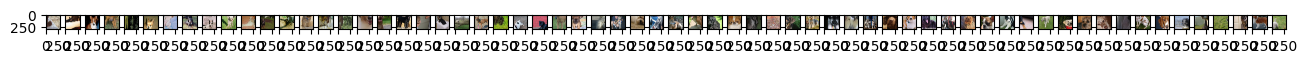

In [24]:
img, label = next(iter(whole_train_dl))
print(len(img), len(label))
fig = plt.figure(1, figsize=(16, 64))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 64), axes_pad=0.05)

for i in range(len(img)):
    ax = grid[i]
    imshow(ax, img[i])

In [25]:
np.random.seed(0)

# **Download pretrained models**

In [26]:
! mkdir -p pretrained-pytorch-models/

In [27]:
!ls pretrained-pytorch-models/

In [28]:
cache_dir = expanduser(join('~', '.torch'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [29]:
!cp -r pretrained-pytorch-models/ ~/.torch/models/

In [30]:
!ls ~/.torch/models

pretrained-pytorch-models


In [31]:
!ls stanford-dogs-dataset

file_list.mat  Images  test.csv  test_list.mat	train.csv  train_list.mat


In [32]:
!wget -c "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth"

--2025-07-07 16:02:37--  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.36, 3.165.102.31, 3.165.102.62, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108857766 (104M) [application/octet-stream]
Saving to: ‘inception_v3_google-1a9a5a14.pth’

inception_v3_google 100%[===================>] 103.81M   206MB/s    in 0.5s    

2025-07-07 16:02:38 (206 MB/s) - ‘inception_v3_google-1a9a5a14.pth’ saved [108857766/108857766]



In [33]:
!mv inception_v3_google-1a9a5a14.pth pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth

# **Define the model**

In [46]:
# Path to the uploaded model file on Kaggle
model_path = 'pretrained-pytorch-models/inception_v3_google-1a9a5a14.pth'

# Load the pretrained model
inception = models.inception_v3(weights=Inception_V3_Weights.DEFAULT)
inception.load_state_dict(torch.load(model_path))

# Freeze all model parameters
for param in inception.parameters():
    param.requires_grad = False

# New final layer with 16 classes (modify if needed)
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs, 120)

# Move the model to GPU if available
inception = inception.to(device)

# **Training loop**

In [47]:
# Training function
def train_model(train_loader, test_loader, model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    lrs = []
    train_accs = []
    train_loss = []
    test_accs = []
    test_loss = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs, aux_outputs = model(inputs)
                loss = criterion(outputs, labels) + criterion(aux_outputs, labels)
                _, preds = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

         # Save the learning rate
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_loss.append(epoch_loss)
        train_accs.append(epoch_acc.cpu().numpy())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

        test_loss.append(epoch_loss)
        test_accs.append(epoch_acc.cpu().numpy())
        print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, lrs, train_loss, train_accs, test_loss, test_accs

# **Define Loss function, optimizer and lr_scheduler**

In [48]:
criterion = torch.nn.CrossEntropyLoss()

# Use named_parameters to get both the name and the parameter
bias_params = [p for name, p in inception.fc.named_parameters() if 'bias' in name]
others = [p for name, p in inception.fc.named_parameters() if 'bias' not in name]

# Create the optimizer with separate parameter groups
optimizer = torch.optim.Adam([
    {'params': others, 'weight_decay':1e-4},
    {'params': bias_params, 'weight_decay': 0}
], lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# **Training the model**

In [49]:
start_time = time.time()
model, lrs, train_loss, train_accs, test_loss, test_accs = train_model(whole_train_dl, test_dl, inception, criterion, optimizer, exp_lr_scheduler, num_epochs=30)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Epoch 0/29
----------
Train Loss: 11.6801 Acc: 0.5192
Test Loss: 0.7311 Acc: 0.8557
Epoch 1/29
----------
Train Loss: 10.4398 Acc: 0.7033
Test Loss: 0.4945 Acc: 0.8834
Epoch 2/29
----------
Train Loss: 10.2755 Acc: 0.7232
Test Loss: 0.4354 Acc: 0.8840
Epoch 3/29
----------
Train Loss: 10.2349 Acc: 0.7370
Test Loss: 0.4019 Acc: 0.8837
Epoch 4/29
----------
Train Loss: 10.1688 Acc: 0.7419
Test Loss: 0.3868 Acc: 0.8852
Epoch 5/29
----------
Train Loss: 10.1620 Acc: 0.7427
Test Loss: 0.3686 Acc: 0.8949
Epoch 6/29
----------
Train Loss: 10.1384 Acc: 0.7476
Test Loss: 0.3676 Acc: 0.8907
Epoch 7/29
----------
Train Loss: 10.1018 Acc: 0.7535
Test Loss: 0.3585 Acc: 0.8917
Epoch 8/29
----------
Train Loss: 10.1023 Acc: 0.7544
Test Loss: 0.3459 Acc: 0.8915
Epoch 9/29
----------
Train Loss: 10.0719 Acc: 0.7635
Test Loss: 0.3477 Acc: 0.8953
Epoch 10/29
----------
Train Loss: 10.0757 Acc: 0.7611
Test Loss: 0.3363 Acc: 0.8969
Epoch 11/29
----------
Train Loss: 10.0685 Acc: 0.7627
Test Loss: 0.3404 Ac

In [50]:
torch.save(model.state_dict(), "model.pt")

# **Visualizations**

In [51]:
def plot_2_graphs(model_name, y_title, x_title, train_y, test_y):
    f1 = plt.figure()

    # plotting the points
    title = model_name + " - " + "Train" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(train_y, label = title)
    title = model_name + " - " + "Test" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(test_y, label = title)

    plt.legend()

    # function to show the plot
    plt.show()

def plot_graph(model_name, y_title, x_title, y):
    f2 = plt.figure()

    # plotting the points
    title = model_name + " - " + "Train" + " - " + y_title + " / " + x_title + " graph!"
    plt.plot(y, label = title)

    plt.legend()

    # function to show the plot
    plt.show()

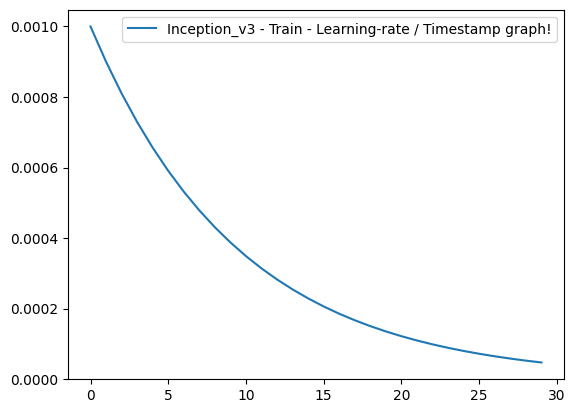

In [52]:
plot_graph("Inception_v3", "Learning-rate", "Timestamp", lrs)

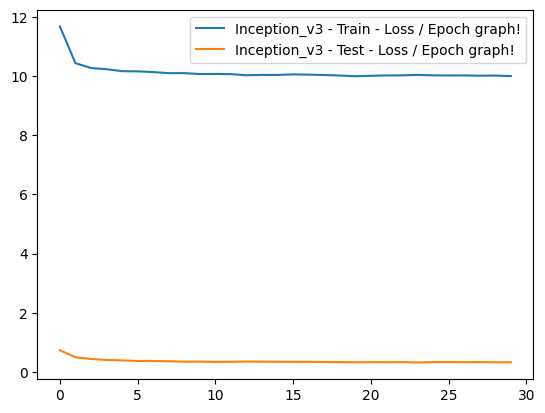

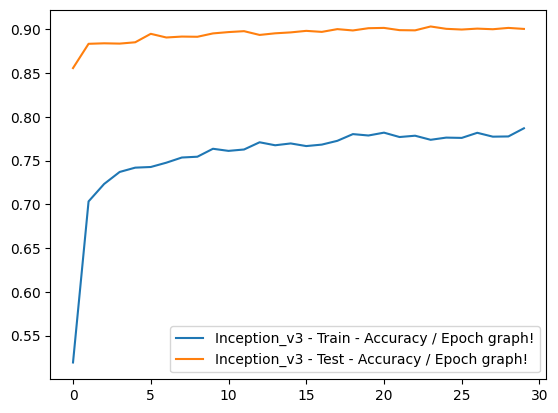

In [53]:
plot_2_graphs("Inception_v3", "Loss", "Epoch", train_loss, test_loss)
plot_2_graphs("Inception_v3", "Accuracy", "Epoch", train_accs, test_accs)

# **Test Loop**

In [54]:
def test_model(dataloader, model, criterion, optimizer, scheduler, num_epochs=5):
    import time
    since = time.time()

    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    running_corrects = 0
    running_topk_corrects = 0
    k = 5  # Set top-k value here

    # Iterate over data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Top-1 prediction
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            # Top-k accuracy
            topk_vals, topk_indices = torch.topk(outputs, k, dim=1)
            correct_topk = topk_indices.eq(labels.view(-1, 1).expand_as(topk_indices))
            running_topk_corrects += correct_topk.any(dim=1).sum()

            running_loss += loss.item() * inputs.size(0)

    dataset_size = len(dataloader.dataset)
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    epoch_topk_acc = running_topk_corrects.double() / dataset_size

    print(f'Loss: {epoch_loss:.4f} | Acc@1: {epoch_acc:.4f} | Acc@{k}: {epoch_topk_acc:.4f}\n')

    time_elapsed = time.time() - since
    print(f'Test complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return epoch_loss, epoch_acc, epoch_topk_acc

# **Testing the model**

In [55]:
start_time = time.time()
test_loss, test_acc, test_topk_acc = test_model(test_dl, model, criterion, optimizer, exp_lr_scheduler, num_epochs=1)
print('Test time: {:10f} minutes'.format((time.time()-start_time)/60))

Loss: 0.3248 | Acc@1: 0.9005 | Acc@5: 0.9930

Test complete in 1m 5s
Test time:   1.076496 minutes


# **Test Accuracy calculation**

In [56]:
print(f'Acc: {test_acc:.4f}, Top-k Acc: {test_topk_acc:.4f}')

Acc: 0.9005, Top-k Acc: 0.9930


# **visualize a single test example**

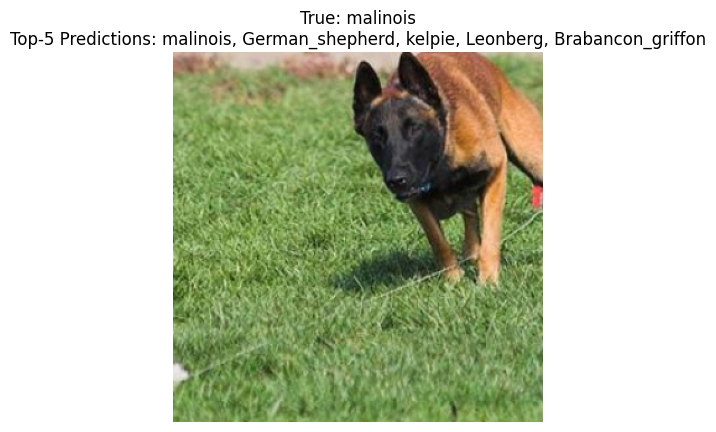

In [58]:
# Function to visualize a single test example with top-k predictions
def visualize_test_example(dataloader, model, k=5):
    model.eval()

    with torch.no_grad():
        # Get a single batch from the dataloader
        inputs, labels = next(iter(dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        topk_vals, topk_indices = torch.topk(outputs, k, dim=1)

        # Choose the image index in the batch to visualize
        image_idx = 1
        input_img = inputs[image_idx].cpu()
        label = labels[image_idx].cpu().item()
        str_label = reverse_encode(shared_encoder, label)
        clean_label = str_label.split('-', 1)[1] if '-' in str_label else str_label

        # Get top-k predictions for this image
        topk_preds = topk_indices[image_idx].cpu().tolist()
        pred_names = []

        for pred in topk_preds:
            str_pred = reverse_encode(shared_encoder, pred)
            clean_pred = str_pred.split('-', 1)[1] if '-' in str_pred else str_pred
            pred_names.append(clean_pred)

        # Denormalize the image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        input_img = input_img.permute(1, 2, 0).numpy() * std + mean
        input_img = np.clip(input_img, 0, 1)

        # Plot the image with label and predictions
        plt.imshow(input_img)
        plt.axis('off')
        title = f"True: {clean_label}\nTop-{k} Predictions: {', '.join(pred_names)}"
        plt.title(title)
        plt.show()

# Call the function
visualize_test_example(test_dl, model, k=5)